# ***TSA & KNN***
----

# QA

## 1.KNN的K值怎么选取？
* KNN中的K值选取对K近邻算法的结果会产生重大影响。如李航博士的一书「统计学习方法」上所说：如果选择较小的K值，就相当于用较小的领域中的训练实例进行预测，“学习”近似误差会减小，只有与输入实例较近或相似的训练实例才会对预测结果起作用，与此同时带来的问题是“学习”的估计误差会增大，换句话说，K值的减小就意味着整体模型变得复杂，容易发生过拟合；如果选择较大的K值，就相当于用较大领域中的训练实例进行预测，其优点是可以减少学习的估计误差，但缺点是学习的近似误差会增大。这时候，与输入实例较远（不相似的）训练实例也会对预测器作用，使预测发生错误，且K值的增大就意味着整体的模型变得简单。
* 一般的方法是对多个备选的k值各自进行交叉验证，计算分类的效果，选择效果最好的k值。
* 经验规则：k一般低于训练样本数的平方根。

## 2.KNN使用是否需要进行标准化，有什么效果？
* 需要进行标准化。KNN是一个基于距离的分类器，其基于对训练集中已标记的观察结果的相似性度量（例如：距离度量）来对于新数据进行分类。标准化使所有变量对相似性度量的贡献相等，能够减轻不同维度量纲不同对距离计算的影响，提高分类的精度

## 3.KNN在特征维度加权有什么效果？
* 计算距离时，每个点的距离增加一个权重，使得距离近的点可以得到更大的权重。可以乘以权重，也有使用各种函数的，包括高斯函数等。
* 有些函数会在距离趋向无穷时返回负的权重，有些则是趋近于零。也有些函数会在距离趋近于0时返回无穷大的权重。选择最适合情况，或者交叉验证效果最好的权重计算方式。
* 经过加权的knn能够更好地处理数据点间的相邻关系


## 4.不平稳时间序列如何处理？
* 对时间序列，如果进行AR,MA等模型建模，一个前提是该序列是平稳的。如果对非平稳的序列进行预测，很有可能得到虚假回归的结果。
* 首先对时间序列进行ADF检验，确定为非平稳序列后，应该进行d阶差分，直到序列为平稳序列。对于这样的序列，计算其ACF和PACF，计算其截尾拖尾的阶数，如果有明显的截尾拖尾就可以建立模型，反之应该进一步分解序列。比如对序列进行STL分解，再以同样方法单独处理T和R序列，直到序列平稳且能够建立AR等模型。

# ***Predict Future Sales***
* To work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 
* To predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.
----

## 1. 先观察数据

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn 

In [2]:
cat = pd.read_csv('item_categories.csv')
cat.head(10)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [3]:
item = pd.read_csv('items.csv')
item.tail()

,item_name,item_id,item_category_id
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62
22169,Яйцо дракона (Игра престолов),22169,69


In [4]:
shop = pd.read_csv('shops.csv')
shop.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [5]:
train = pd.read_csv('sales_train.csv')
train.head(20)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [6]:
test = pd.read_csv('test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
len(set(train['item_id'])), len(set(test['item_id']))

(21807, 5100)

----
## 2.数据规模观察和筛选
对于售卖软件的企业来说，考虑到软件、游戏等商品更新换代速度很快，两年的训练集数据时间跨度是较大的。根据上面的观察，最后需要预测的商品只有5100种，而训练集里有21807种，可以认为其他商品已经过时了。为了避免在过于稀疏的数据上操作，所以首要目标是提取test.csv中需要预测的商品集合，并且根据这个集合缩小训练集。

考虑到不同商店的同种商品需要分开预测，应该构造一个新的特征，即商店id和商品id的组合，从而唯一地代表某商店的某种商品。



In [8]:
train['x_id'] = train['shop_id'].astype('str') +'-'+ train['item_id'] .astype('str')
test['x_id'] = test['shop_id'].astype('str') +'-'+ test['item_id'] .astype('str')

In [9]:
len(set(train['x_id'])), len(set(test['x_id']))

(424124, 214200)

In [10]:
true_id = pd.DataFrame({'x_id':test.x_id.values})
n_train = pd.merge(train, true_id, on='x_id', how='inner')
len(train), len(n_train), len(set(n_train.x_id))

(2935849, 1224439, 111404)

In [11]:
(214200-111404)/214200

0.479906629318394

In [12]:
# df1 = pd.DataFrame({'x_id':[1,2,3,4,5,6,5,5,4,3,6,2,9], 'count':[1,2,3,4,5,6,7,8,9,10,11,12,13]})

# df2 = pd.DataFrame({'x_id':[1,4,5,26]})

# pd.merge(df1, df2, on='x_id', how='inner')

In [13]:
'5-5268' in train.x_id.values, '5-5268' in test.x_id.values

(False, True)

-----
结果发现有将近48%的预测目标（x_id:商店-商品组合）没有在训练集里出现过,也就是说过去的两年里这些商店并没有出售过些商品，现在却要在接下来的一个月预测销量？这是为什么?难道是是训练集不完整？

In [14]:
len(set(train.shop_id)), len(set(test.shop_id))

(60, 42)

In [15]:
sum(test.shop_id==5), sum(test.shop_id==6), sum(test.shop_id==41)   

(5100, 5100, 5100)

In [16]:
len(test)/5100 == len(set(test.shop_id))

True

----
看来test表只是简单地将需要预测的所有5100种产品映射到了所有42家商店上，产生了不符合现实的组合。因此将所有训练集中未出现过的组合当做不存在，也就是直接赋为0即可，所以之前取得的筛选过的n_train还是可以继续使用的。接下来对数据进行聚合，以月份的粒度取得所有shop-item组合的销售量时间序列。



In [17]:
date =  [list(x) for x in n_train.date]
date = np.array(date)
def exchange(date, a,b,c,d):
    s1 = date[:, a:b].copy()
    date[:, a:b] = date[:, c:d]  
    date[:, c:d] = s1
exchange(date, 0,4,6,10)
exchange(date, 6,8,8,10)
exchange(date, 4,5,6,7)
exchange(date, 5,6,7,8)
date_lis = date.copy()
date = [''.join(x) for x in date_lis]
n_train['date'] = date
n_train['date'] = pd.to_datetime(n_train['date'])
n_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,x_id
0,2013-01-02,0,59,22154,999.0,1.0,59-22154
1,2013-01-03,0,25,2574,399.0,2.0,25-2574
2,2013-01-05,0,25,2574,399.0,1.0,25-2574
3,2013-01-07,0,25,2574,399.0,1.0,25-2574
4,2013-01-08,0,25,2574,399.0,2.0,25-2574
...,...,...,...,...,...,...,...
1224434,2015-10-22,33,25,7327,349.0,1.0,25-7327
1224435,2015-10-24,33,25,7315,399.0,1.0,25-7315
1224436,2015-10-31,33,25,7409,299.0,1.0,25-7409
1224437,2015-10-09,33,25,7409,299.0,1.0,25-7409


In [18]:
aggr=n_train.groupby(['x_id','date_block_num'])['date','item_price','item_cnt_day'].agg({'date':['min','max'],'item_price':'mean','item_cnt_day':'sum'})

D:\programs\envs\python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [19]:
aggr

date            item_price item_cnt_day
                               min        max       mean          sum
x_id     date_block_num                                              
10-10003 19             2014-08-08 2014-08-08       73.0          1.0
10-10007 11             2013-12-31 2013-12-31      255.0          1.0
         19             2014-08-30 2014-08-30      255.0          1.0
10-10029 2              2013-03-06 2013-03-06     1320.0          1.0
10-10039 4              2013-05-18 2013-05-18      190.0          1.0
...                            ...        ...        ...          ...
7-9986   21             2014-10-24 2014-10-24      199.0          1.0
         23             2014-12-30 2014-12-30      199.0          1.0
         25             2015-02-01 2015-02-01      199.0          1.0
         26             2015-03-21 2015-03-23      199.0          2.0
         33             2015-10-04 2015-10-04      199.0          1.0

[600159 rows x 4 columns]

----
找到销售周期最长的产品之一，观察销售的时间序列数据

In [20]:
# len_list = [len(aggr.loc[i[0]]) for i in aggr.index]
# maxid = len_list.index(max(len_list))


In [21]:
# x_id = [x[0] for x in aggr.index]
      


In [22]:
# remain=[]
# for i in range(len(x_id)-1):
#     ins = x_id[i]
#     nex = x_id[i+1]
#     if ins != nex and i+1!=len(x_id):
#         remain.append(i)
#     elif ins != nex and i+1==len(x_id):
#         remain.append(i+1)
        
# len_df = pd.DataFrame({'x_id':x_id,'len':len_list})
# len_df = len_df.iloc[remain]
# len_df.to_csv('len.csv')

In [23]:
len_df = pd.read_csv('len.csv')
len_df['len'].describe()

count    111403.000000
mean          5.387189
std           5.613484
min           1.000000
25%           2.000000
50%           3.000000
75%           7.000000
max          34.000000
Name: len, dtype: float64

D:\programs\envs\python36\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='len', ylabel='Density'>

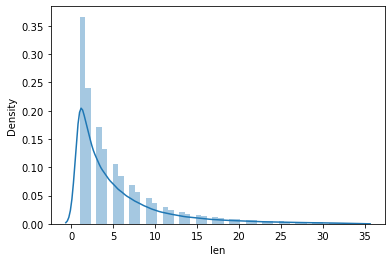

In [24]:
sns.distplot(len_df['len'])

maxid is 7494

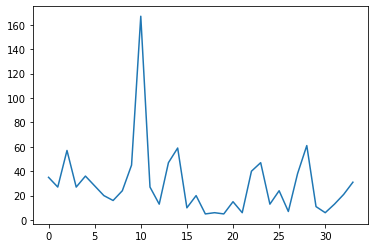

In [25]:
month = aggr.loc['12-11365'].index
sales = aggr.loc['12-11365']['item_cnt_day']
plt.plot(month, sales)

----
可以看到7成以上的商品组合的生命周期都在半年以内，能销售两年的商品组合屈指可数。观察这类商品组合，其时间序列规律性比较明显，趋势下降不明显。试试不考虑预测前三个月没有销量的商品。

In [26]:
# has_sales=[]
# for i in [x[0] for x in aggr.index]:
#     df  = aggr.loc[i]
#     life = set(df.index)
#     if len(life & set([31,32,33])) > 0:
#         has_sales.append(i)
    

# len(has_sales)
# has_sales_df = pd.DataFrame({'x_id':has_sales})
# has_sales_df.to_csv('has_sales.csv')

In [27]:
# has_sales = pd.read_csv('has_sales.csv').x_id.values
# has_sales = list(set(has_sales) & set(len_df['x_id']))
# len(has_sales)
# has_sales_df = pd.DataFrame({'x_id':has_sales})
# has_sales_df.to_csv('has_sales.csv')

----
通过删去前三个月没有销量，且不在预测目标列表里的商品组合，现在只剩下五万多条商品时间序列。随便找几个用prophet预测一下看看。

In [28]:
has_sales = pd.read_csv('has_sales.csv').x_id.values


In [29]:
len_df.set_index('x_id').loc[has_sales]['len'].describe()

count    55944.000000
mean         6.645735
std          6.574335
min          1.000000
25%          2.000000
50%          4.000000
75%          9.000000
max         34.000000
Name: len, dtype: float64

D:\programs\envs\python36\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='len', ylabel='Density'>

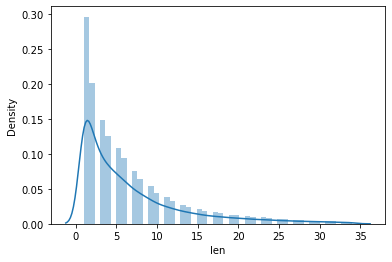

In [30]:
sns.distplot(len_df.set_index('x_id').loc[has_sales]['len'])

In [31]:
date = aggr.loc[has_sales[30800]]['date']['min']
sales = aggr.loc[has_sales[30800]]['item_cnt_day']['sum']
df = pd.DataFrame({'ds':date, 'y':sales})
# df['y'] = (df['y'] - df['y'].mean())/df['y'].std()

In [32]:
sales

date_block_num
8     6.0
9     2.0
11    2.0
14    1.0
18    3.0
20    1.0
26    3.0
28    4.0
31    1.0
32    1.0
Name: sum, dtype: float64

In [38]:
df

,ds,y
date_block_num,,
8,2013-09-07,6.0
9,2013-10-05,2.0
11,2013-12-14,2.0
14,2014-03-27,1.0
18,2014-07-09,3.0
20,2014-09-13,1.0
26,2015-03-07,3.0
28,2015-05-07,4.0
31,2015-08-28,1.0


In [458]:
from fbprophet import Prophet
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods = 1, freq='M')
future.tail()
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


In [459]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-09-07,1.044921,1.347273,4.943748,1.044921,1.044921,1.997235,1.997235,1.997235,1.997235,1.997235,1.997235,0.0,0.0,0.0,3.042156
1,2013-10-05,1.012626,1.266184,4.869285,1.012626,1.012626,1.997235,1.997235,1.997235,1.997235,1.997235,1.997235,0.0,0.0,0.0,3.009861
2,2013-12-14,0.931889,1.105024,4.762400,0.931889,0.931889,1.997235,1.997235,1.997235,1.997235,1.997235,1.997235,0.0,0.0,0.0,2.929124
3,2014-03-27,0.813090,0.977844,4.542715,0.813090,0.813090,1.928920,1.928920,1.928920,1.928920,1.928920,1.928920,0.0,0.0,0.0,2.742010
4,2014-07-09,0.693138,0.460489,4.018321,0.693138,0.693138,1.560078,1.560078,1.560078,1.560078,1.560078,1.560078,0.0,0.0,0.0,2.253216
5,2014-09-13,0.617014,0.828968,4.454242,0.617014,0.617014,1.997235,1.997235,1.997235,1.997235,1.997235,1.997235,0.0,0.0,0.0,2.614249
6,2015-03-07,0.415171,0.551290,4.300477,0.415171,0.415171,1.997235,1.997235,1.997235,1.997235,1.997235,1.997235,0.0,0.0,0.0,2.412406
7,2015-05-07,0.344814,0.334810,4.058469,0.344814,0.344814,1.928920,1.928920,1.928920,1.928920,1.928920,1.928920,0.0,0.0,0.0,2.273734
8,2015-08-28,0.214481,-0.815171,2.753895,0.214481,0.214481,0.802675,0.802675,0.802675,0.802675,0.802675,0.802675,0.0,0.0,0.0,1.017156
9,2015-09-02,0.208714,-0.096808,3.539103,0.208714,0.208714,1.560078,1.560078,1.560078,1.560078,1.560078,1.560078,0.0,0.0,0.0,1.768792


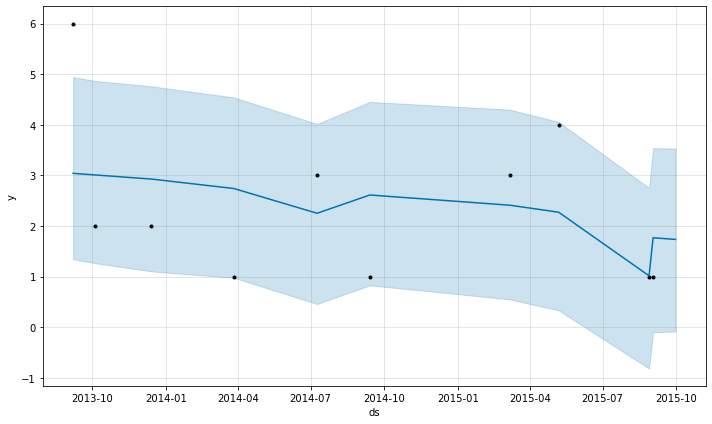

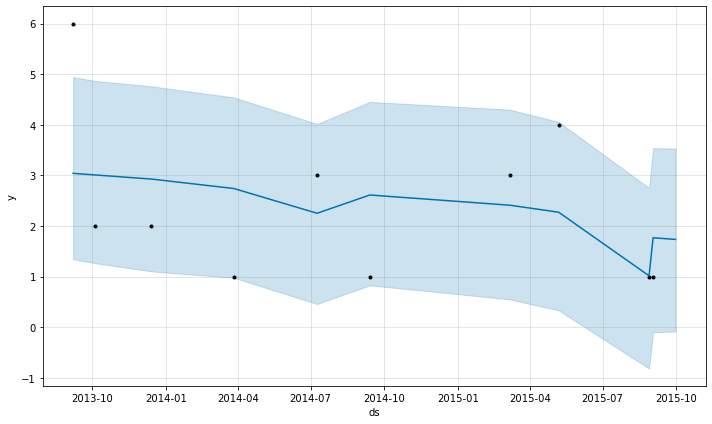

In [460]:
m.plot(forecast)

----
## 3. 预测思路
虽然有很大部分的序列只有一两个元素，不需要复杂的预测方法，但是仍然至少有两万多的序列包含超过6个过去月份的数据，用prophet一个一个预测的话可能要两万秒，这样预测的速度有些慢了。

考虑从预测商店层面的销量数据入手，然后对每种类别的商品分别预测销量，得到每种类别的占比，结合该产品在生命周期内的在其cat的平均销量占比，再结合前面筛选的结果进行分配。

下面先预测shop的销量

In [461]:

aggr_shop = n_train.groupby(['shop_id','date_block_num'])['item_cnt_day','date'].agg({'item_cnt_day':'sum','date':'min'})
aggr_shop



D:\programs\envs\python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


item_cnt_day       date
shop_id date_block_num                         
2       0                      248.0 2013-01-01
        1                      135.0 2013-02-09
        2                      237.0 2013-03-01
        3                      168.0 2013-04-01
        4                      159.0 2013-05-01
...                              ...        ...
59      29                     807.0 2015-06-01
        30                     885.0 2015-07-01
        31                    1163.0 2015-08-01
        32                     857.0 2015-09-01
        33                     770.0 2015-10-01

[1327 rows x 2 columns]

In [462]:
list(aggr_shop.loc[36]['item_cnt_day'])

[324.0]

In [463]:

# from fbprophet import Prophet
# shop_id = set([x[0] for x in aggr_shop.index])
# shop_pred = []
# new_shop = []
# for i in shop_id:
#     print(i)
#     cell = aggr_shop.loc[i]
#     if len(cell) >= 2:
#         df = pd.DataFrame({'ds':cell['date'], 'y':cell['item_cnt_day']})
#         m = Prophet()
#         m.fit(df)
#         future = m.make_future_dataframe(periods = 1, freq='M')
#         forecast = m.predict(future)
#         shop_pred.append(forecast['yhat'].loc[len(forecast)-1])
#     else:
#         shop_pred.append(list(cell['item_cnt_day'])[0])
# shop_pred_df = pd.DataFrame({'shop_id':list(shop_id), 'shop_pred':shop_pred})
# shop_pred_df.to_csv('shop_pred.csv')
shop_pred_df = pd.read_csv('shop_pred.csv')

In [464]:
n_train = pd.merge(n_train, shop_pred_df)
n_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,x_id,shop_pred
0,2013-01-02,0,59,22154,999.0,1.0,59-22154,2085.130504
1,2013-01-04,0,59,5643,2390.0,1.0,59-5643,2085.130504
2,2013-01-17,0,59,5643,2390.0,2.0,59-5643,2085.130504
3,2013-01-19,0,59,5643,2390.0,1.0,59-5643,2085.130504
4,2013-02-02,1,59,5643,2390.0,2.0,59-5643,2085.130504
...,...,...,...,...,...,...,...,...
1224434,2015-10-30,33,36,20231,169.0,1.0,36-20231,324.000000
1224435,2015-10-18,33,36,20334,1949.0,1.0,36-20334,324.000000
1224436,2015-10-31,33,36,20339,1549.0,1.0,36-20339,324.000000
1224437,2015-10-31,33,36,20352,1549.0,1.0,36-20352,324.000000


In [465]:
test = pd.merge(test, shop_pred_df)
test

,ID,shop_id,item_id,x_id,shop_pred
0,0,5,5037,5-5037,841.842502
1,1,5,5320,5-5320,841.842502
2,2,5,5233,5-5233,841.842502
3,3,5,5232,5-5232,841.842502
4,4,5,5268,5-5268,841.842502
...,...,...,...,...,...
214195,214195,45,18454,45-18454,1597.026285
214196,214196,45,16188,45-16188,1597.026285
214197,214197,45,15757,45-15757,1597.026285
214198,214198,45,19648,45-19648,1597.026285


----
下面预测每个category的销量

In [466]:
items = pd.read_csv('items.csv').drop(['item_name'],axis=1)
n_train = pd.merge(n_train, items)
test = pd.merge(test, items)
n_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,x_id,shop_pred,item_category_id
0,2013-01-02,0,59,22154,999.0,1.0,59-22154,2085.130504,37
1,2013-01-02,0,25,22154,999.0,1.0,25-22154,5485.254286,37
2,2013-01-03,0,25,22154,999.0,1.0,25-22154,5485.254286,37
3,2013-01-20,0,25,22154,999.0,1.0,25-22154,5485.254286,37
4,2013-01-23,0,25,22154,999.0,1.0,25-22154,5485.254286,37
...,...,...,...,...,...,...,...,...,...
1224434,2015-10-29,33,55,12733,1490.0,1.0,55-12733,1994.175126,76
1224435,2015-10-28,33,55,12733,1490.0,1.0,55-12733,1994.175126,76
1224436,2015-10-28,33,55,1819,1499.0,3.0,55-1819,1994.175126,31
1224437,2015-10-29,33,55,1819,1499.0,1.0,55-1819,1994.175126,31


In [467]:
aggr_cat = n_train.groupby(['item_category_id','date_block_num'])['item_cnt_day','date'].agg({'item_cnt_day':'sum','date':'min'})
aggr_cat

D:\programs\envs\python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


item_cnt_day       date
item_category_id date_block_num                         
2                0                      293.0 2013-01-01
                 1                      232.0 2013-02-01
                 2                      171.0 2013-03-01
                 3                      126.0 2013-04-01
                 4                      159.0 2013-05-02
...                                       ...        ...
83               29                     245.0 2015-06-01
                 30                     287.0 2015-07-01
                 31                     286.0 2015-08-01
                 32                     277.0 2015-09-01
                 33                     345.0 2015-10-01

[1660 rows x 2 columns]

In [468]:
# from fbprophet import Prophet
# item_category_id = set([x[0] for x in aggr_cat.index])
# cat_pred = []
# for i in item_category_id:
#     print(i)
#     cell = aggr_cat.loc[i]
#     if len(cell) >= 2:
#         df = pd.DataFrame({'ds':cell['date'], 'y':cell['item_cnt_day']})
#         m = Prophet()
#         m.fit(df)
#         future = m.make_future_dataframe(periods = 1, freq='M')
#         forecast = m.predict(future)
#         cat_pred.append(forecast['yhat'].loc[len(forecast)-1])
#     else:
#         cat_pred.append(list(cell['item_cnt_day'])[0])

# cat_pred_df = pd.DataFrame({'item_category_id':list(item_category_id), 'cat_pred':cat_pred})
# cat_pred_df.to_csv('cat_pred.csv')


In [469]:
cat_pred_df = pd.read_csv('cat_pred.csv')

In [470]:
test = pd.merge(test, cat_pred_df, how = 'outer')
n_train = pd.merge(n_train, cat_pred_df)

In [471]:
n_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,x_id,shop_pred,item_category_id,cat_pred
0,2013-01-02,0,59,22154,999.0,1.0,59-22154,2085.130504,37,0.0
1,2013-01-02,0,25,22154,999.0,1.0,25-22154,5485.254286,37,0.0
2,2013-01-03,0,25,22154,999.0,1.0,25-22154,5485.254286,37,0.0
3,2013-01-20,0,25,22154,999.0,1.0,25-22154,5485.254286,37,0.0
4,2013-01-23,0,25,22154,999.0,1.0,25-22154,5485.254286,37,0.0
...,...,...,...,...,...,...,...,...,...,...
1224434,2015-09-22,32,55,13094,2500.0,2.0,55-13094,1994.175126,36,3.0
1224435,2015-09-26,32,55,5386,3990.0,1.0,55-5386,1994.175126,74,2.0
1224436,2015-09-30,32,55,5386,3990.0,1.0,55-5386,1994.175126,74,2.0
1224437,2015-10-06,33,55,5386,3990.0,1.0,55-5386,1994.175126,74,2.0


----
下面计算前三个月中，x_id的item销量和shop预测值的比值向量，以及此item销量和其cat销量的比值向量，最后进行线性组合得到所有预测item的销量。

In [472]:
tri_mon = n_train.loc[list(n_train['date_block_num']>=31)]
tri_mon

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,x_id,shop_pred,item_category_id,cat_pred
6,2015-08-27,31,25,22154,299.0,1.0,25-22154,5485.254286,37,0.0
7,2015-09-02,32,25,22154,299.0,1.0,25-22154,5485.254286,37,0.0
9,2015-10-10,33,24,22154,299.0,1.0,24-22154,2952.284499,37,0.0
10,2015-08-04,31,21,22154,299.0,1.0,21-22154,1560.258114,37,0.0
13,2015-10-11,33,28,22154,299.0,1.0,28-22154,4002.642743,37,0.0
...,...,...,...,...,...,...,...,...,...,...
1224434,2015-09-22,32,55,13094,2500.0,2.0,55-13094,1994.175126,36,3.0
1224435,2015-09-26,32,55,5386,3990.0,1.0,55-5386,1994.175126,74,2.0
1224436,2015-09-30,32,55,5386,3990.0,1.0,55-5386,1994.175126,74,2.0
1224437,2015-10-06,33,55,5386,3990.0,1.0,55-5386,1994.175126,74,2.0


In [473]:

cat_hist_sale_aggr = tri_mon.groupby('item_category_id')['item_cnt_day'].agg([('item_cnt_day','sum')])
cat_hist_sale_aggr['cat_hist_sale'] = cat_hist_sale_aggr['item_cnt_day']
cat_hist_sale_aggr.drop(['item_cnt_day'], axis=1, inplace=True)
cat_hist_sale_aggr.reset_index(inplace=True)
cat_hist_sale_aggr.head()

,item_category_id,cat_hist_sale
0,2,262.0
1,3,3082.0
2,5,114.0
3,6,737.0
4,7,748.0


In [474]:
tri_mon = pd.merge(tri_mon, cat_hist_sale_aggr)

In [475]:
tri_mon

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,x_id,shop_pred,item_category_id,cat_pred,cat_hist_sale
0,2015-08-27,31,25,22154,299.0,1.0,25-22154,5485.254286,37,0.0,9495.0
1,2015-09-02,32,25,22154,299.0,1.0,25-22154,5485.254286,37,0.0,9495.0
2,2015-10-10,33,24,22154,299.0,1.0,24-22154,2952.284499,37,0.0,9495.0
3,2015-08-04,31,21,22154,299.0,1.0,21-22154,1560.258114,37,0.0,9495.0
4,2015-10-11,33,28,22154,299.0,1.0,28-22154,4002.642743,37,0.0,9495.0
...,...,...,...,...,...,...,...,...,...,...,...
146788,2015-09-22,32,55,13094,2500.0,2.0,55-13094,1994.175126,36,3.0,3.0
146789,2015-09-26,32,55,5386,3990.0,1.0,55-5386,1994.175126,74,2.0,4.0
146790,2015-09-30,32,55,5386,3990.0,1.0,55-5386,1994.175126,74,2.0,4.0
146791,2015-10-06,33,55,5386,3990.0,1.0,55-5386,1994.175126,74,2.0,4.0


In [476]:
aggr_item = tri_mon.groupby(['item_id','item_category_id'])['item_cnt_day','cat_hist_sale'].agg({'item_cnt_day':'sum','cat_hist_sale':'mean'})
aggr_item

D:\programs\envs\python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,,item_cnt_day,cat_hist_sale
item_id,item_category_id,,
30,40,9.0,19563.0
31,37,79.0,9495.0
32,40,71.0,19563.0
33,37,46.0,9495.0
38,41,9.0,972.0
...,...,...,...
22162,40,31.0,19563.0
22163,40,74.0,19563.0
22164,37,44.0,9495.0


In [477]:

# item_cat_coef = aggr_item['item_cnt_day']/aggr_item['cat_hist_sale']
# item_cat_coef = pd.DataFrame(item_cat_coef)
# item_cat_coef.reset_index(inplace=True)
# item_cat_coef.rename(columns={0:'item_cat_coef'}, inplace=True)
# item_cat_coef.to_csv('item_cat_coef.csv')


item_cat_coef = pd.read_csv('item_cat_coef.csv')

In [478]:
shop_hist_sale_aggr = tri_mon.groupby('shop_id')['item_cnt_day'].agg([('item_cnt_day','sum')])
shop_hist_sale_aggr['shop_hist_sale'] = shop_hist_sale_aggr['item_cnt_day']
shop_hist_sale_aggr.drop(['item_cnt_day'], axis=1, inplace=True)
shop_hist_sale_aggr.reset_index(inplace=True)
shop_hist_sale_aggr.head()

,shop_id,shop_hist_sale
0,2,2377.0
1,3,1882.0
2,4,2405.0
3,5,3291.0
4,6,4795.0


In [479]:

tri_mon = pd.merge(tri_mon, shop_hist_sale_aggr)
tri_mon

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,x_id,shop_pred,item_category_id,cat_pred,cat_hist_sale,shop_hist_sale
0,2015-08-27,31,25,22154,299.0,1.0,25-22154,5485.254286,37,0.0,9495.0,14973.0
1,2015-09-02,32,25,22154,299.0,1.0,25-22154,5485.254286,37,0.0,9495.0,14973.0
2,2015-10-10,33,25,8095,399.0,1.0,25-8095,5485.254286,37,0.0,9495.0,14973.0
3,2015-10-30,33,25,8095,399.0,1.0,25-8095,5485.254286,37,0.0,9495.0,14973.0
4,2015-08-23,31,25,16595,99.0,1.0,25-16595,5485.254286,37,0.0,9495.0,14973.0
...,...,...,...,...,...,...,...,...,...,...,...,...
146788,2015-09-22,32,55,13094,2500.0,2.0,55-13094,1994.175126,36,3.0,3.0,4110.0
146789,2015-09-26,32,55,5386,3990.0,1.0,55-5386,1994.175126,74,2.0,4.0,4110.0
146790,2015-09-30,32,55,5386,3990.0,1.0,55-5386,1994.175126,74,2.0,4.0,4110.0
146791,2015-10-06,33,55,5386,3990.0,1.0,55-5386,1994.175126,74,2.0,4.0,4110.0


In [480]:
aggr_item = tri_mon.groupby(['item_id','shop_id'])['item_cnt_day','shop_hist_sale'].agg({'item_cnt_day':'sum','shop_hist_sale':'mean'})
aggr_item


D:\programs\envs\python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


item_cnt_day  shop_hist_sale
item_id shop_id                              
30      5                 1.0          3291.0
        6                 1.0          4795.0
        14                1.0          2933.0
        25                1.0         14973.0
        26                1.0          3842.0
...                       ...             ...
22167   39                1.0          2685.0
        42               11.0         11857.0
        47                1.0          5582.0
        50                1.0          2811.0
        52                2.0          2739.0

[55945 rows x 2 columns]

In [481]:

# item_shop_coef = aggr_item['item_cnt_day']/aggr_item['shop_hist_sale']
# item_shop_coef = pd.DataFrame(item_shop_coef)
# item_shop_coef.rename(columns={0:'item_shop_coef'}, inplace=True)
# item_shop_coef.reset_index(inplace=True)
# item_shop_coef['x_id'] = item_shop_coef['shop_id'].astype('str') + '-' + item_shop_coef['item_id'].astype('str')
# item_shop_coef.drop(['item_id','shop_id'], axis=1, inplace=True)
# item_shop_coef.to_csv('item_shop_coef.csv', index=False)
item_shop_coef = pd.read_csv('item_shop_coef.csv')
item_shop_coef

,item_shop_coef,x_id
0,0.000304,5-30
1,0.000209,6-30
2,0.000341,14-30
3,0.000067,25-30
4,0.000260,26-30
...,...,...
55940,0.000372,39-22167
55941,0.000928,42-22167
55942,0.000179,47-22167
55943,0.000356,50-22167


In [482]:
set(test.shop_id) - set(n_train.shop_id), set(test.item_category_id) - set(n_train.item_category_id)


(set(), {0, 27})

----
两方面系数计算完成。顺便检验一下，可以发现虽然商品组合有出新，但是测试集没有开出新店或出现新类型的产品。现在看训练集。

In [487]:
test

,ID,shop_id,item_id,x_id,shop_pred,item_category_id,cat_pred,item_shop_coef,item_cat_coef
0,0,5,5037,5-5037,841.842502,19,12212.583790,0.001215,0.023494
1,5100,4,5037,4-5037,1415.465873,19,12212.583790,0.001247,0.023494
2,10200,6,5037,6-5037,2461.626527,19,12212.583790,0.000417,0.023494
3,15300,3,5037,3-5037,1258.820680,19,12212.583790,NaN,0.023494
4,20400,2,5037,2-5037,1288.851132,19,12212.583790,0.000841,0.023494
...,...,...,...,...,...,...,...,...,...
214195,193262,46,168,46-168,1965.437493,44,1.123611,NaN,NaN
214196,198362,41,168,41-168,1190.157797,44,1.123611,NaN,NaN
214197,203462,44,168,44-168,935.932847,44,1.123611,NaN,NaN
214198,208562,39,168,39-168,862.510215,44,1.123611,NaN,NaN


In [486]:
test = pd.merge(test, item_shop_coef, how='outer')

test = pd.merge(test, item_cat_coef, how='outer')

test.to_csv('n_test.csv')

----
## 4. 预测
准备好了数据集，可以进行预测值的计算了。将shop预测值乘以item-shop系数，将cat预测值乘以item-cat系数，再筛去之前认为没有销量的商品组合，分别计算出预测结果并尝试提交。最后再尝试将两个结果进行组合形成新的预测。

In [488]:
test = pd.read_csv('n_test.csv')
test = test.fillna(0)
test

,Unnamed: 0,ID,shop_id,item_id,x_id,shop_pred,item_category_id,cat_pred,item_shop_coef,item_cat_coef
0,0,0,5,5037,5-5037,841.842502,19,12212.583790,0.001215,0.023494
1,1,5100,4,5037,4-5037,1415.465873,19,12212.583790,0.001247,0.023494
2,2,10200,6,5037,6-5037,2461.626527,19,12212.583790,0.000417,0.023494
3,3,15300,3,5037,3-5037,1258.820680,19,12212.583790,0.000000,0.023494
4,4,20400,2,5037,2-5037,1288.851132,19,12212.583790,0.000841,0.023494
...,...,...,...,...,...,...,...,...,...,...
214195,214195,193262,46,168,46-168,1965.437493,44,1.123611,0.000000,0.000000
214196,214196,198362,41,168,41-168,1190.157797,44,1.123611,0.000000,0.000000
214197,214197,203462,44,168,44-168,935.932847,44,1.123611,0.000000,0.000000
214198,214198,208562,39,168,39-168,862.510215,44,1.123611,0.000000,0.000000


In [489]:
test['item_shop_pred'] = test['shop_pred'] * test['item_shop_coef']

test['item_cat_pred'] = test['cat_pred'] * test['item_cat_coef']

In [490]:
test.loc[test.item_shop_pred.copy()>20,'item_shop_pred'] = 20
test.loc[test.item_shop_pred.copy()<0,'item_shop_pred'] = 0
test.loc[test.item_cat_pred.copy()>20,'item_cat_pred'] = 20
test.loc[test.item_cat_pred.copy()<0,'item_cat_pred'] = 0

(214200, 158340, 53550)

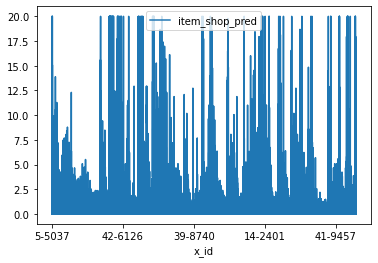

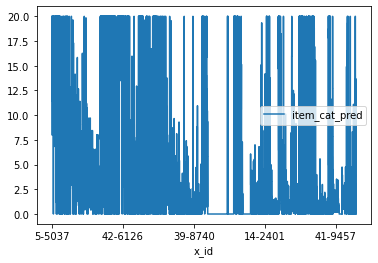

In [491]:

test.plot(x='x_id', y=['item_shop_pred'])
test.plot(x='x_id', y=['item_cat_pred'])

len(test), sum(test.item_shop_pred==0),  sum(test.item_cat_pred==0)

In [492]:
has_sales

array(['48-7853', '6-5552', '56-13409', ..., '5-17772', '39-8656',
       '50-2753'], dtype=object)

In [493]:
has_sales = pd.read_csv('has_sales.csv')
has_sales['has_sales_coef'] = 1
test = pd.merge(test, has_sales, on='x_id', how='outer')
test = test.fillna(0)
test
 

,Unnamed: 0_x,ID,shop_id,item_id,x_id,shop_pred,item_category_id,cat_pred,item_shop_coef,item_cat_coef,item_shop_pred,item_cat_pred,Unnamed: 0_y,has_sales_coef
0,0,0,5,5037,5-5037,841.842502,19,12212.583790,0.001215,0.023494,1.023206,20.0,48291.0,1.0
1,1,5100,4,5037,4-5037,1415.465873,19,12212.583790,0.001247,0.023494,1.765654,20.0,41753.0,1.0
2,2,10200,6,5037,6-5037,2461.626527,19,12212.583790,0.000417,0.023494,1.026747,20.0,53151.0,1.0
3,3,15300,3,5037,3-5037,1258.820680,19,12212.583790,0.000000,0.023494,0.000000,20.0,0.0,0.0
4,4,20400,2,5037,2-5037,1288.851132,19,12212.583790,0.000841,0.023494,1.084435,20.0,46104.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,193262,46,168,46-168,1965.437493,44,1.123611,0.000000,0.000000,0.000000,0.0,0.0,0.0
214196,214196,198362,41,168,41-168,1190.157797,44,1.123611,0.000000,0.000000,0.000000,0.0,0.0,0.0
214197,214197,203462,44,168,44-168,935.932847,44,1.123611,0.000000,0.000000,0.000000,0.0,0.0,0.0
214198,214198,208562,39,168,39-168,862.510215,44,1.123611,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [494]:
test['item_shop_pred'] = test['item_shop_pred'] * test['has_sales_coef']
test['item_cat_pred'] = test['item_cat_pred'] * test['has_sales_coef']


(214200, 158341, 165255)

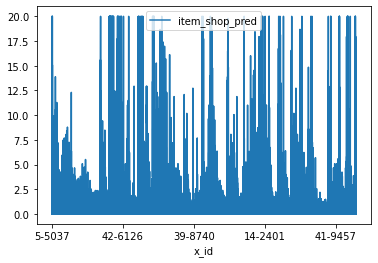

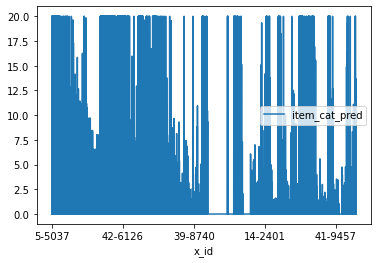

In [495]:

test.plot(x='x_id', y=['item_shop_pred'])
test.plot(x='x_id', y=['item_cat_pred'])

len(test), sum(test.item_shop_pred==0),  sum(test.item_cat_pred==0)

In [496]:
test['final_pred'] = 0.3*test['item_cat_pred'] + 0.7*test['item_shop_pred']

In [497]:
test = test.set_index('ID').sort_index()

In [498]:
def submission(ver, result):
    df = pd.read_csv('sample_submission.csv')
    df['item_cnt_month'] = result
    filename = 'submission_'+str(ver)+'.csv'
    df.to_csv(filename, index=False)


In [499]:
submission('shop', test['item_shop_pred'])

In [500]:
test

,Unnamed: 0_x,shop_id,item_id,x_id,shop_pred,item_category_id,cat_pred,item_shop_coef,item_cat_coef,item_shop_pred,item_cat_pred,Unnamed: 0_y,has_sales_coef,final_pred
ID,,,,,,,,,,,,,,
0,0,5,5037,5-5037,841.842502,19,12212.583790,0.001215,0.023494,1.023206,20.000000,48291.0,1.0,6.716244
1,5880,5,5320,5-5320,841.842502,55,3375.720381,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2,42,5,5233,5-5233,841.842502,19,12212.583790,0.001519,0.025266,1.279007,20.000000,6216.0,1.0,6.895305
3,34104,5,5232,5-5232,841.842502,23,6295.479942,0.000304,0.015256,0.255801,20.000000,7150.0,1.0,6.179061
4,40320,5,5268,5-5268,841.842502,20,6493.710308,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,34061,45,18454,45-18454,1597.026285,55,3375.720381,0.000510,0.000375,0.814809,1.266925,24740.0,1.0,0.950444
214196,168419,45,16188,45-16188,1597.026285,64,170.294906,0.000000,0.001486,0.000000,0.000000,0.0,0.0,0.000000
214197,34103,45,15757,45-15757,1597.026285,55,3375.720381,0.000000,0.000751,0.000000,0.000000,0.0,0.0,0.000000
